# Промышленность


Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами, установленными на крышке ковша.      
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.          
Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

In [1]:
!pip install skorch

     |████████████████████████████████| 239 kB 1.1 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor  
from skorch.callbacks import EpochScoring, EarlyStopping 

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = 'navy'
plt.rcParams["grid.alpha"] = 0.15
CMAP = 'coolwarm'

RANDOM_STATE = 190224

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE);

## Загрузка данных


In [3]:
db_config = {
'user': '***', # имя пользователя
'pwd': '***', # пароль
'host': '***',
'port': 1111, # порт подключения
'db': '***' # название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                         db_config['pwd'],
                                                         db_config['host'],
                                                         db_config['port'],
                                                         db_config['db'])
engine = create_engine(connection_string)

Данные хранятся в базе данных PostgreSQL, которая состоит из нескольких таблиц:
- steel.data_arc — данные об электродах;
- steel.data_bulk — данные об объёме сыпучих материалов;
- steel.data_bulk_time — данные о времени подачи сыпучих материалов;
- steel.data_gas — данные о продувке сплава газом;
- steel.data_temp — данные об измерениях температуры;
- steel.data_wire — данные об объёме проволочных материалов;
- steel.data_wire_time — данные о времени подачи проволочных материалов.

Проверим, все ли таблицы на месте и какие в них столбцы:

In [4]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema = 'steel'
'''
tables = pd.read_sql_query(sql=query, con=engine)['table_name'].tolist()
print('Список таблиц:', tables)

Список таблиц: ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']


In [5]:
def get_table_info(table):
    query1 = '''SELECT *
                FROM steel.''' + table +\
             '''
                LIMIT 3;
             '''
    query2 = '''SELECT COUNT(*)
                FROM steel.''' + table +\
             ''';
             '''
    query3 = '''SELECT COUNT(DISTINCT key)
                FROM steel.''' + table +\
             ''';
             '''
    print('Таблица:', table)
    display(pd.read_sql_query(sql=query1, con=engine))
    print('Количество записей:', pd.read_sql_query(sql=query2, con=engine).loc[0, 'count'])
    print('Количество партий:', pd.read_sql_query(sql=query3, con=engine).loc[0, 'count'])
    print('▬'*100)

In [6]:
for n in tables:
    get_table_info(n)

Таблица: data_arc


,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805


Количество записей: 14876
Количество партий: 3214
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_bulk


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0


Количество записей: 3129
Количество партий: 3129
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_bulk_time


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40


Количество записей: 3129
Количество партий: 3129
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_gas


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793


Количество записей: 3239
Количество партий: 3239
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_temp


,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0


Количество записей: 15907
Количество партий: 3216
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_wire


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None


Количество записей: 3081
Количество партий: 3081
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
Таблица: data_wire_time


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None


Количество записей: 3081
Количество партий: 3081
▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬


В базе есть все таблицы, указанные в описании. Во всех таблицах, кроме `data_wire` и `data_wire_time`, есть все столбцы, описанные заказчиком.

Количество записей в таблицах различается, в двух из них содержится по несколько записей на партию. Для решения задачи нужно агрегировать их, оставив по одной записи на партию - модель будет предсказывать температуру сплава после всех этапов обработки, а не на каждом этапе.

## Исследование и предобработка данных

### Исследование

#### data_arc

В таблице `data_arc` содержатся данные об электродах:
- key — номер партии;
- BeginHeat и EndHeat — время начала и окончания нагрева;
- ActivePower — значение активной мощности;
- ReactivePower — значение реактивной мощности.

In [7]:
query = '''
SELECT *
FROM steel.data_arc;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_arc;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])
pd.read_sql_query(sql=query, con=engine).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            14876 non-null  int64  
 1   BeginHeat      14876 non-null  object 
 2   EndHeat        14876 non-null  object 
 3   ActivePower    14876 non-null  float64
 4   ReactivePower  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
Уникальных ключей: 3214


,key,ActivePower,ReactivePower
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Пропусков нет. В столбце ReactivePower есть аномально маленькое значение. Вряд ли мощность может быть отрицательной - проверим, есть ли еще значения меньше нуля:

In [8]:
query = '''
SELECT *
FROM steel.data_arc
WHERE "ReactivePower" < 0;
'''
pd.read_sql_query(sql=query, con=engine)

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,2116,00:44:48,00:46:37,0.495782,-715.504924


Отрицательное значение всего одно. Уберем всю партию, в которой появилась аномалия, и посмотрим, как распределены мощности:

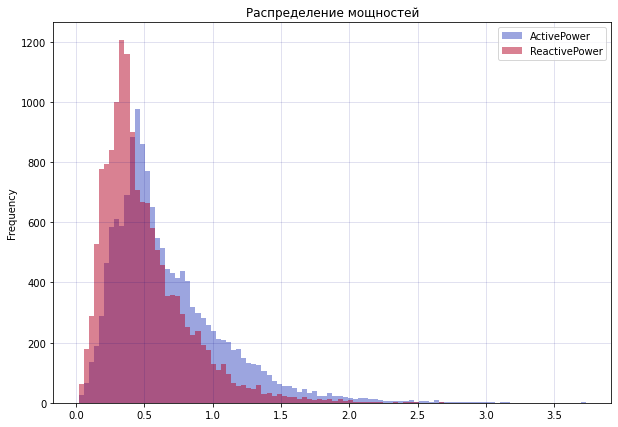

In [9]:
query = '''
SELECT "ActivePower",
       "ReactivePower"
FROM steel.data_arc
WHERE key NOT IN (SELECT DISTINCT key AS bad_keys
                 FROM steel.data_arc
                 WHERE "ReactivePower" < 0);
'''
pd.read_sql_query(sql=query, con=engine).plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP, grid=True,
                                              title='Распределение мощностей',
                                              xlabel='мощность', ylabel='частота');

В ReactivePower чаще встречаются значения меньше 0.5. У ActivePower в целом значения мощности выше, чем у ReactivePower. Значения больше 2 встречаются очень редко у каждого типа мощности.

Теперь посмотрим на время. Проверим, есть ли записи, где время окончания нагрева меньше времени начала:

In [10]:
query = '''
SELECT EXTRACT(EPOCH FROM "BeginHeat") / 3600 AS begin_Time,
       EXTRACT(EPOCH FROM "EndHeat") / 3600 AS end_time
FROM steel.data_arc
WHERE "EndHeat" < "BeginHeat";
'''
pd.read_sql_query(sql=query, con=engine).describe()

,begin_time,end_time
count,22.000000,22.000000
mean,23.966982,0.030997
std,0.024117,0.027913
min,23.881944,0.001944
25%,23.960069,0.012083
50%,23.974861,0.027361
75%,23.981181,0.036319
max,23.993056,0.118611


Всего таких записей 22. Начало нагрева каждой близко к 12 ночи, а конец переходит на новый день. Время начала больше не из-за аномалии в замерах.

Дальше можно сгенерировать новые признаки.      
Само по себе время нагрева для прогноза будет бесполезно - вместо него рассчитаем длительность нагрева. Дополнительно посчитаем количество нагреваний в каждой партии, среднее время одного нагрева и общее время нагрева партии.        
На графике распределения мощности было видно, что активная мощность в целом больше, чем реактивная - как новый признак можно взять разницу между ними или их соотношение.       
После рассчета дополнительных признаков агрегируем их - для каждой партии найдем среднее значение мощностей и времени нагрева:

In [11]:
arcs_query = '''
arcs AS
   (SELECT key,
           CASE
               WHEN "EndHeat" < "BeginHeat" THEN
                    EXTRACT(EPOCH FROM ("EndHeat" - "BeginHeat")) + 86400
               ELSE EXTRACT(EPOCH FROM ("EndHeat" - "BeginHeat"))
               END AS heat_seconds, -- время нагрева в секундах
           "ActivePower",
           "ReactivePower",
           "ActivePower" / "ReactivePower" AS power_ratio
    FROM steel.data_arc
    ORDER BY key),
arcs_fin AS 
    (SELECT key,
           COUNT(key) AS heat_count, -- количество нагреваний в одной партии
           SUM(heat_seconds) AS total_heat_seconds, -- общее время нагревания
           AVG("ActivePower") AS avg_active, -- средняя активная мощность
           AVG("ReactivePower") AS avg_reactive, -- средняя реактивная мощность
           AVG(power_ratio) AS avg_ratio -- среднее соотношение активной к реактивной мощности
    FROM arcs
    WHERE key NOT IN (SELECT DISTINCT key
                     FROM steel.data_arc
                     WHERE "ReactivePower" < 0 -- исключаем аномалию в ReactivePower
                        OR "ReactivePower" > 2 -- убираем очень редкие значения
                        OR "ActivePower" > 2)
    GROUP BY key)
'''
query = '''
WITH '''+\
arcs_query +\
'''
SELECT *
FROM arcs_fin;
'''
arc_data = pd.read_sql_query(sql=query, con=engine)

In [12]:
display(arc_data.head(3))
arc_data.info()
display(arc_data.describe())

,key,heat_count,total_heat_seconds,avg_active,avg_reactive,avg_ratio
0,1,5,1098.0,0.975629,0.636648,1.538898
1,2,4,811.0,0.763150,0.499528,1.551834
2,3,5,655.0,0.505176,0.319815,1.583120


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 3039 non-null   int64  
 1   heat_count          3039 non-null   int64  
 2   total_heat_seconds  3039 non-null   float64
 3   avg_active          3039 non-null   float64
 4   avg_reactive        3039 non-null   float64
 5   avg_ratio           3039 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 142.6 KB


,key,heat_count,total_heat_seconds,avg_active,avg_reactive,avg_ratio
count,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000
mean,1622.916420,4.584403,765.754525,0.650668,0.487766,1.354545
std,932.660127,1.586449,304.848266,0.188880,0.143102,0.131825
min,1.000000,1.000000,57.000000,0.186226,0.130062,0.676106
25%,824.500000,4.000000,558.000000,0.511900,0.381995,1.289992
50%,1614.000000,4.000000,750.000000,0.629834,0.478328,1.367598
75%,2430.500000,5.500000,949.500000,0.774672,0.581297,1.434960
max,3241.000000,16.000000,2919.000000,1.390464,1.134983,1.782164


В новой таблице осталось 3039 записей - по одной на партию. Пропусков нет. В столбце `heat_count` есть партия с 16 нагревами, а одну партию нагревали 48 минут. Посмотрим, как распределены значения признаков:

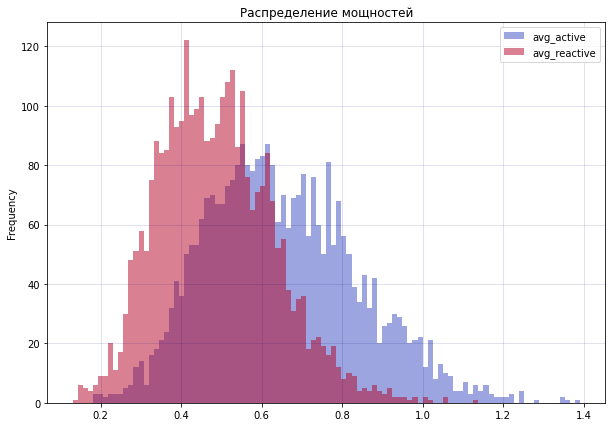

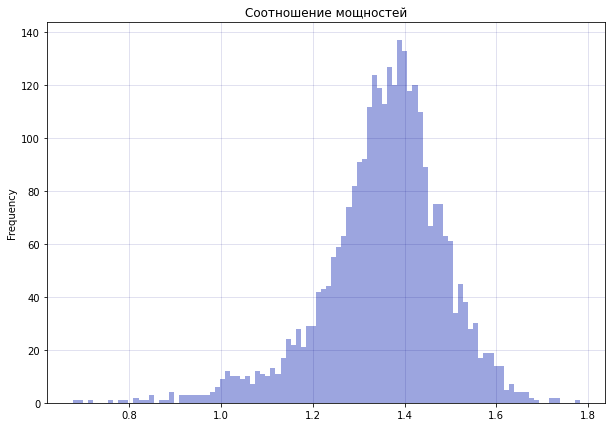

In [13]:
arc_data[['avg_active', 'avg_reactive']].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                           title='Распределение мощностей',
                                           xlabel='мощность', ylabel='частота');
plt.show()
arc_data['avg_ratio'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                           title='Соотношение мощностей',
                                           xlabel='мощность', ylabel='частота');

Средние значения реактивной мощности обычно находятся в диапазоне от 0.3 до 0.65, активная мощность обычно больше - от 0.4 до 0.9. Соотношение активной мощности к реактивной чаще всего равно 1.4 и обычно находится в пределах от 1.2 до 1.5. Редко бывает так, что активная мощность меньше реактивной.

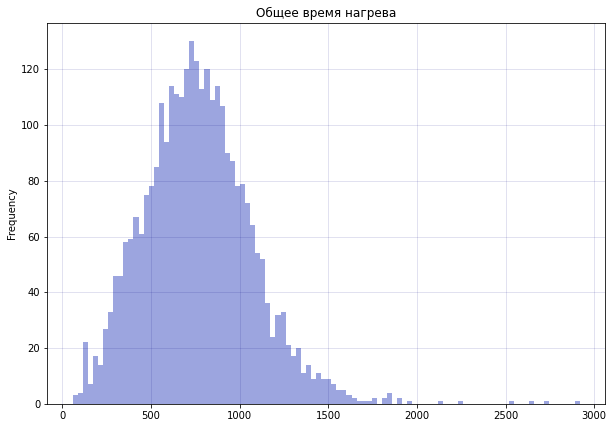

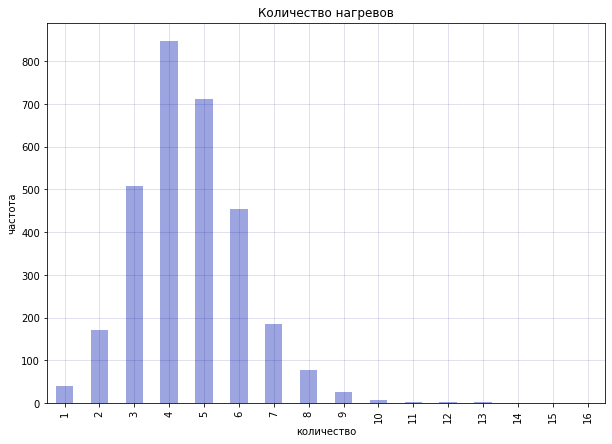

In [14]:
arc_data['total_heat_seconds'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                 title='Общее время нагрева',
                                 xlabel='время', ylabel='частота');
plt.show()
arc_data['heat_count'].value_counts().sort_index()\
                       .plot(kind='bar', alpha=0.5, cmap=CMAP,
                             title='Количество нагревов',
                             xlabel='количество', ylabel='частота');

Партию чаще всего нагревают 4 или 5 раз, в среднем общее время нагрева партии - от 500 до 1000 секунд. Редко партию приходится нагревать больше 9 раз, время нагрева также редко превышает 1600 секунд.

Напишем небольшой фильтр для выбивающихся значений во времени и количестве нагревов:

In [15]:
arcs_filter = '''
      arcs_fin.heat_count < 10
  AND arcs_fin.total_heat_seconds < 1600
'''
query = '''
WITH '''+\
arcs_query +\
'''
SELECT *
FROM arcs_fin
WHERE''' +\
arcs_filter +\
''';
'''
pd.read_sql_query(sql=query, con=engine)

,key,heat_count,total_heat_seconds,avg_active,avg_reactive,avg_ratio
0,1,5,1098.0,0.975629,0.636648,1.538898
1,2,4,811.0,0.763150,0.499528,1.551834
2,3,5,655.0,0.505176,0.319815,1.583120
3,4,4,741.0,0.802313,0.515074,1.563487
4,5,4,869.0,0.836793,0.563161,1.480428
...,...,...,...,...,...,...
3000,3237,5,909.0,0.786493,0.565692,1.384203
3001,3238,3,546.0,0.702176,0.560394,1.257794
3002,3239,8,1216.0,0.583344,0.388952,1.497918
3003,3240,5,839.0,0.596817,0.496653,1.257343


#### data_gas

В таблице `data_gas` данные о продувке сплава газом - номер партии и количество газа.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
Уникальных ключей: 3239


,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


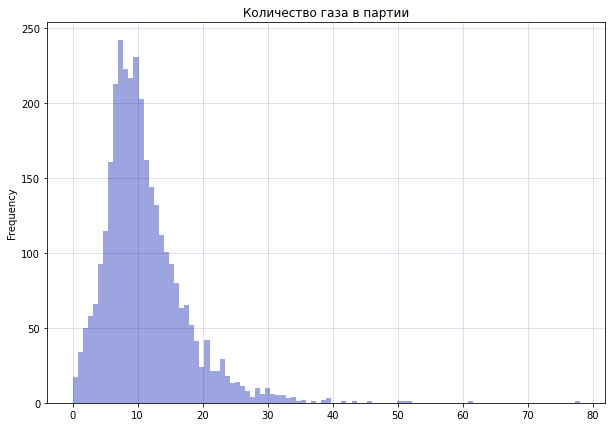

In [16]:
query = '''
SELECT *
FROM steel.data_gas;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_gas;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])
display(pd.read_sql_query(sql=query, con=engine).describe())
pd.read_sql_query(sql=query, con=engine)['gas'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                                     title='Количество газа в партии',
                                                     xlabel='количество', ylabel='частота');

На каждую партию в данных есть одна запись. Количество использованного газа обычно от 5 до 15, редко на продув стали приходится тратить больше 35. На графике видно несколько выбивающихся значений близко к 50, 60 и 80 - избавимся от них и от редких значений:

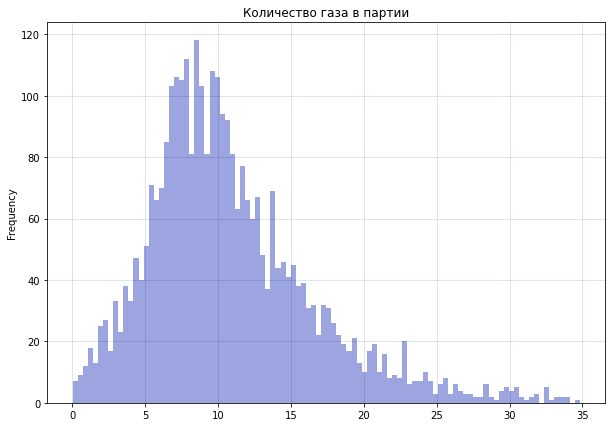

In [17]:
gas_query = '''
gas_fin AS 
    (SELECT *
    FROM steel.data_gas
    WHERE gas < 35)
'''
query = '''
WITH '''+\
gas_query +\
'''
SELECT *
FROM gas_fin;
'''
pd.read_sql_query(sql=query, con=engine)['gas'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                                     title='Количество газа в партии',
                                                     xlabel='количество', ylabel='частота');

Готов запрос для таблицы `data_gas`.

#### data_bulk

В `data_bulk` содержатся данные об объёме подаваемого сыпучего материала.

In [18]:
query = '''
SELECT *
FROM steel.data_bulk;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_bulk;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
Уникальных ключей: 3129


Всего есть 15 разных материалов. В данных очень много пропусков - они означают, что материал не добавляли в партию, а значит их можно заполнить нулем. В некоторых столбцах меньше 100 значений, есть столбец всего с одним значением - признаки, большей частью состоящие из нулей будут бесполезны для предсказания.

In [19]:
bulk_data = pd.read_sql_query(sql=query, con=engine)
bulk_data.count().sort_values(ascending=False)

key        3129
Bulk 14    2806
Bulk 12    2450
Bulk 15    2248
Bulk 3     1298
Bulk 4     1014
Bulk 6      576
Bulk 1      252
Bulk 11     177
Bulk 10     176
Bulk 5       77
Bulk 7       25
Bulk 2       22
Bulk 9       19
Bulk 13      18
Bulk 8        1
dtype: int64

Всего таких столбцов 6. Удалим их и посмотрим, как распределены значения в остальных:

In [20]:
bulklist = bulk_data.count()[bulk_data.count() > 100].drop('key').index.values
bulk_data[bulklist].describe().drop('count')\
                   .style.background_gradient(cmap=CMAP, axis=1)

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
mean,39.242063,113.879045,104.394477,118.925347,83.284091,76.819209,260.471020,170.284747,160.513345
std,18.277654,75.483494,48.184126,72.057776,26.060347,59.655365,120.649269,65.868652,51.765319
min,10.000000,6.000000,12.000000,17.000000,24.000000,8.000000,53.000000,16.000000,1.000000
25%,27.000000,58.000000,72.000000,69.750000,64.000000,25.000000,204.000000,119.000000,105.000000
50%,31.000000,97.500000,102.000000,100.000000,86.500000,64.000000,208.000000,151.000000,160.000000
75%,46.000000,152.000000,133.000000,157.000000,102.000000,106.000000,316.000000,205.750000,205.000000
max,185.000000,454.000000,281.000000,503.000000,159.000000,313.000000,1849.000000,636.000000,405.000000


Материал `Bulk 12` добавляют в самых больших количествах, но даже для него максимальное значение в 1849 выглядит как выброс.

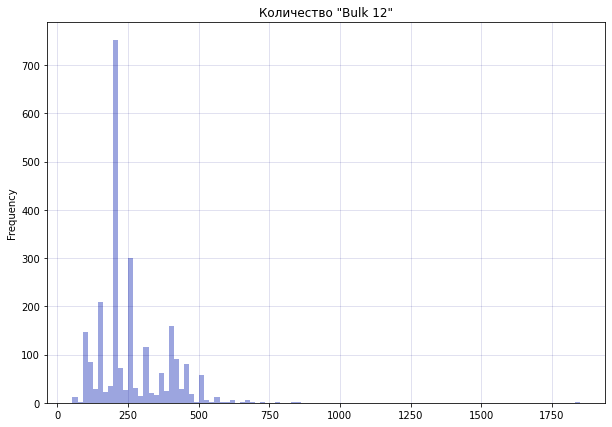

In [21]:
bulk_data['Bulk 12'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                          title='Количество "Bulk 12"',
                          xlabel='количество', ylabel='частота');

Этот материал обычно добавляют в количестве 200-250, больше 600 его почти никогда не кладут.

In [22]:
bulk_data[bulklist].drop(bulk_data[bulk_data['Bulk 12'] > 600].index)\
                   .describe().drop('count')\
                   .style.background_gradient(cmap=CMAP, axis=1)

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
mean,38.144068,113.972910,104.429283,118.719512,83.274286,77.405714,256.496708,169.382986,160.343638
std,15.551849,75.609898,48.117793,71.983368,26.134800,59.740348,110.317979,64.557893,51.717934
min,10.000000,6.000000,12.000000,17.000000,24.000000,8.000000,53.000000,16.000000,1.000000
25%,27.000000,57.750000,72.000000,69.250000,64.000000,25.000000,204.000000,119.000000,105.000000
50%,31.000000,97.500000,102.000000,100.000000,87.000000,64.000000,208.000000,151.000000,160.000000
75%,46.000000,152.000000,133.250000,156.750000,102.000000,106.500000,314.000000,205.000000,205.000000
max,118.000000,454.000000,281.000000,503.000000,159.000000,313.000000,597.000000,601.000000,405.000000


Без выбросов в `Bulk 12` стало видно, что других материалов также могут добавлять по 400-600 единиц. В основном добавляют от 50 до 200. Меньше всего добавляют `Bulk 1`.

Подготовим запрос для `data_bulk`:

In [23]:
bulk_query = '''
bulk_fin AS
    (SELECT key,
            "''' + '", "'.join(bulklist.tolist()) + '''"
    FROM steel.data_bulk
    WHERE key NOT IN (SELECT key
                      FROM steel.data_bulk
                      WHERE "Bulk 12" > 600)
    )
'''
query = '''
WITH '''+\
bulk_query +\
'''
SELECT *
FROM bulk_fin;
'''
pd.read_sql_query(sql=query, con=engine)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,1,NaN,NaN,43.0,NaN,NaN,NaN,206.0,150.0,154.0
1,2,NaN,NaN,73.0,NaN,NaN,NaN,206.0,149.0,154.0
2,3,NaN,NaN,34.0,NaN,NaN,NaN,205.0,152.0,153.0
3,4,NaN,NaN,81.0,NaN,NaN,NaN,207.0,153.0,154.0
4,5,NaN,NaN,78.0,NaN,NaN,NaN,203.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...
3104,3237,NaN,170.0,NaN,NaN,NaN,NaN,252.0,130.0,206.0
3105,3238,NaN,126.0,NaN,NaN,NaN,NaN,254.0,108.0,106.0
3106,3239,NaN,NaN,NaN,114.0,NaN,NaN,158.0,270.0,88.0
3107,3240,NaN,NaN,NaN,26.0,NaN,NaN,NaN,192.0,54.0


#### data_bulk_time

В `data_bulk_time` содержатся данные о времени подачи сыпучих материалов.

In [24]:
query = '''
SELECT *
FROM steel.data_bulk_time;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_bulk_time;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
Уникальных ключей: 3129


Похоже, что data_bulk и data_bulk_time содержат данные об одинаковых партиях - количество пропусков в столбцах такое же.

Для каждого материала здесь указано время подачи. Само по себе время будет бесполезно для прогноза - температура не может зависеть от времени суток; рассчитать, сколько времени ушло на добавление материала не выйдет, ведь нет времени окончания подачи. Можно только проверить, нет ли партий с аномально большой разницей в подаче первого и последнего материала.

Переведем время в секунды и найдем максимальное и минимальное значение, а также разницу между ними:

In [25]:
bulk_data = pd.DataFrame([*pd.read_sql_query(sql=query, con=engine)[bulklist]\
                              .apply(lambda x: [y.hour * 3600 + y.minute * 60 + y.second if y else y for y in x], axis=1)],
                              columns=bulklist)
bulk_data.head(3)

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15
0,NaN,NaN,40890.0,NaN,NaN,NaN,39832.0,39832.0,39832.0
1,NaN,NaN,42398.0,NaN,NaN,NaN,42020.0,42020.0,42020.0
2,NaN,NaN,45066.0,NaN,NaN,NaN,43780.0,43780.0,43780.0


In [26]:
bulk_data[['max', 'min']] = [*bulk_data.apply(lambda x: [x.max(), x.min()], axis=1)]
bulk_data['diff'] = bulk_data['max'] - bulk_data['min']
display(bulk_data.head(3))
bulk_data['diff'].describe()

,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,max,min,diff
0,NaN,NaN,40890.0,NaN,NaN,NaN,39832.0,39832.0,39832.0,40890.0,39832.0,1058.0
1,NaN,NaN,42398.0,NaN,NaN,NaN,42020.0,42020.0,42020.0,42398.0,42020.0,378.0
2,NaN,NaN,45066.0,NaN,NaN,NaN,43780.0,43780.0,43780.0,45066.0,43780.0,1286.0


count     3119.000000
mean      1093.721706
std       6735.711786
min          0.000000
25%        207.000000
50%        413.000000
75%        738.500000
max      86198.000000
Name: diff, dtype: float64

Во времени подачи есть большая разница - это снова могут быть замеры около полуночи.

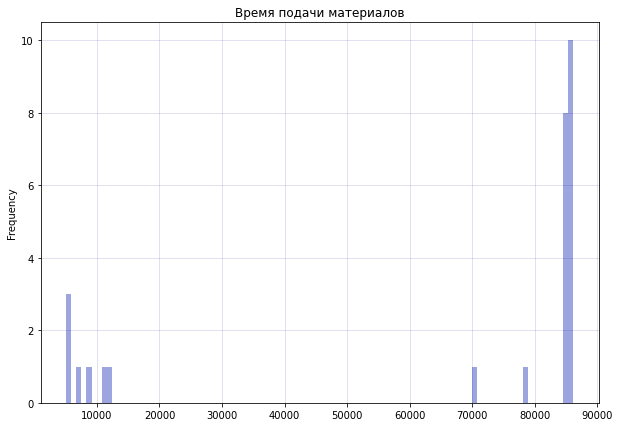

In [28]:
bulk_data[bulk_data['diff']>5000]['diff'].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                               title='Время подачи материалов',
                                               xlabel='время', ylabel='частота');

10000 секунд это довольно много, но не так много как 80000 - это почти сутки.

In [29]:
(bulk_data[bulk_data['diff'] > 60000][['max' , 'min']] / 3600).describe()

,max,min
count,20.000000,20.000000
mean,23.621639,0.166375
std,0.752135,0.261792
min,20.700833,0.000278
25%,23.715903,0.028819
50%,23.863611,0.061667
75%,23.920069,0.173194
max,23.981667,1.053333


Замеры у всех партий с большой разницей происходили с 11 до 1 ночи - снова не аномалии в данных.       
Использовать эту таблицу для создания признаков не будем.

#### data_wire

В `data_wire` лежат данные о количестве проволочных материалов.

In [30]:
query = '''
SELECT *
FROM steel.data_wire;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_wire;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
Уникальных ключей: 3081


В этой таблице 9 разных материалов. Здесь пропусков еще больше - только в столбцах `Wire 1` и `Wire 2` значений больше 100.       
Посмотрим, как распределено количество материалов:

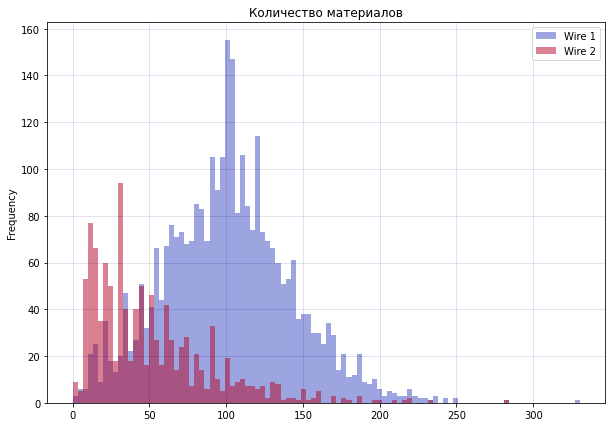

In [31]:
query = '''
SELECT "Wire 1",
       "Wire 2"
FROM steel.data_wire;
'''
pd.read_sql_query(sql=query, con=engine).plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                              title='Количество материалов',
                                              xlabel='количество', ylabel='частота');

`Wire 1` чаще добавляют в количестве от 50 до 150, `Wire 2` - от 10 до 50. Первый материал редко добавляют больше 200, второй - больше 150.

Уберем редкие значения и составим запрос:

In [32]:
wire_query = '''
wire_fin AS
    (SELECT key,
            "Wire 1",
            "Wire 2"
    FROM steel.data_wire
    WHERE key NOT IN (SELECT key
                      FROM steel.data_wire
                      WHERE "Wire 2" > 150
                        OR "Wire 1" > 200)
    )
'''
query = '''
WITH '''+\
wire_query +\
'''
SELECT *
FROM wire_fin;
'''
pd.read_sql_query(sql=query, con=engine)

,key,Wire 1,Wire 2
0,1,60.059998,NaN
1,2,96.052315,NaN
2,3,91.160157,NaN
3,4,89.063515,NaN
4,5,89.238236,9.11456
...,...,...,...
3003,3237,38.088959,NaN
3004,3238,56.128799,NaN
3005,3239,143.357761,NaN
3006,3240,34.070400,NaN


#### data_wire_time

В `data_wire_time` хранится время подачи проволочных материалов.

In [33]:
query = '''
SELECT *
FROM steel.data_wire_time;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_wire_time;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
Уникальных ключей: 3081


Количество уникальных ключей и пропусков здесь совпадает с `data_wire`. Также как для `data_bulk_time` проверим разницу во времени подачи материалов:

In [34]:
query2 = '''
SELECT *
FROM steel.data_wire_time;
'''
wire_time = pd.read_sql_query(sql=query2, con=engine)

In [35]:
query = '''
SELECT "Wire 1",
       "Wire 2"
FROM steel.data_wire_time;
'''
wire_data = pd.DataFrame([*pd.read_sql_query(sql=query, con=engine)\
                              .apply(lambda x: [y.hour * 3600 + y.minute * 60 + y.second if y else y for y in x], axis=1)],
                              columns=['Wire 1', 'Wire 2'])
wire_data.head(3)

,Wire 1,Wire 2
0,40301.0,NaN
1,42370.0,NaN
2,44027.0,NaN


In [36]:
wire_data[['max', 'min']] = [*wire_data.apply(lambda x: [x.max(), x.min()], axis=1)]
wire_data['diff'] = wire_data['max'] - wire_data['min']
display(wire_data.head(3))
wire_data['diff'].describe()

,Wire 1,Wire 2,max,min,diff
0,40301.0,NaN,40301.0,40301.0,0.0
1,42370.0,NaN,42370.0,42370.0,0.0
2,44027.0,NaN,44027.0,44027.0,0.0


count     3070.000000
mean       220.094788
std       3094.966894
min          0.000000
25%          0.000000
50%          0.000000
75%         70.750000
max      86046.000000
Name: diff, dtype: float64

In [37]:
wire_data[wire_data['diff'] > 10000] / 3600

,Wire 1,Wire 2,max,min,diff
389,23.973333,0.166111,23.973333,0.166111,23.807222
701,23.933889,0.032222,23.933889,0.032222,23.901667
1224,23.681667,0.187778,23.681667,0.187778,23.493889
1785,23.857500,0.093889,23.857500,0.093889,23.763611


Больше 3 часов только записи с разницей почти 24 часа, и все они рядом с полночью, что не удивительно.        
Эту таблицу также не будем присоединять к остальным.

#### data_temp

В `data_temp` хранятся данные о температуре сплава:
- key — номер партии;
- MesaureTime — время замера;
- Temperature — значение температуры.

В каждой партии может быть несколько замеров. В этой таблице содержится целевой признак - температура последнего замера в партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры нельзя использовать как входные - это приведет к утечке целевого признака.

In [38]:
query = '''
SELECT *
FROM steel.data_temp;
'''
query2 = '''
SELECT COUNT(DISTINCT key)
FROM steel.data_temp;
'''
pd.read_sql_query(sql=query, con=engine).info()
print('Уникальных ключей:', pd.read_sql_query(sql=query2, con=engine)['count'][0])
pd.read_sql_query(sql=query, con=engine).describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   MesaureTime  15907 non-null  object 
 2   Temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
Уникальных ключей: 3216


,key,Temperature
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


В таблице 15907 записей и всего 3216 партий. В температурах есть пропуски - такие записи нам точно не нужны.      
Посчитаем количество замеров для каждой партии и для скольки замеров была указана температура. Если температура будет указана не для всех, данные об этой партии придется удалить.

In [39]:
query = '''
SELECT  key, 
        COUNT("key") AS key_count,
        COUNT("Temperature") AS temp_count
FROM steel.data_temp
GROUP BY key
HAVING COUNT("Temperature") < COUNT("key");
'''
pd.read_sql_query(sql=query, con=engine).describe()

,key,key_count,temp_count
count,739.000000,739.000000,739.0
mean,2869.852503,4.925575,1.0
std,213.963364,1.736312,0.0
min,2500.000000,2.000000,1.0
25%,2685.500000,4.000000,1.0
50%,2870.000000,5.000000,1.0
75%,3054.500000,6.000000,1.0
max,3241.000000,13.000000,1.0


Во всех 739 партиях с пропусками была указана всего одна температура. Для обучения нужно взять температуру первого и последнего замера - партии всего с одним значением автоматически не попадут в данные, так что дополнительно обрабатывать партии с пропусками не нужно.

Проверим, нет ли партий, в которых время первого замера больше последнего:

In [40]:
query = '''
WITH 
time_sec AS 
    (SELECT  key,
            FIRST_VALUE(EXTRACT(EPOCH FROM "MesaureTime")) OVER (PARTITION BY key),
            LAST_VALUE(EXTRACT(EPOCH FROM "MesaureTime")) OVER (PARTITION BY key)
    FROM steel.data_temp)
SELECT DISTINCT key,
        first_value / 3600 AS first_value,
        last_value / 3600 AS last_value,
        (last_value - first_value) / 3600 AS diff
FROM time_sec
WHERE last_value - first_value < 0;
'''
pd.read_sql_query(sql=query, con=engine).describe()

,key,first_value,last_value,diff
count,71.000000,71.000000,71.000000,71.000000
mean,1558.859155,23.512821,0.347465,-23.165356
std,992.944687,0.556969,0.508613,0.871858
min,18.000000,20.586111,0.007500,-23.860556
25%,693.500000,23.359167,0.086111,-23.592500
50%,1515.000000,23.705556,0.232500,-23.335000
75%,2423.000000,23.849167,0.398611,-23.163889
max,3147.000000,23.994167,3.248056,-18.736667


Таких партий 71, и снова замеры происходят рядом с 12 ночи, только в этот раз размах больше - примерно с 20:30 до 3:30. Максимальная разница между замерами - 5.5 часов.

Убедились, что замеры сделаны по порядку. Теперь найдем температуру первого и последнего замера:

In [41]:
query = '''
WITH
temp_counts AS 
    (SELECT DISTINCT key,
            FIRST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime"),
            LAST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime" ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING),
            COUNT("Temperature") OVER (PARTITION BY key)
    FROM steel.data_temp)
SELECT *
FROM temp_counts
WHERE count > 1
ORDER BY key;
'''
display(pd.read_sql_query(sql=query, con=engine).head(3))
pd.read_sql_query(sql=query, con=engine).drop('key', axis=1).describe()

,key,first_value,last_value,count
0,1,1571.0,1613.0,5
1,2,1581.0,1602.0,6
2,3,1596.0,1599.0,5


,first_value,last_value,count
count,2475.000000,2475.000000,2475.000000
mean,1588.344242,1595.140606,4.955556
std,29.142672,16.216640,1.807323
min,1191.000000,1530.000000,2.000000
25%,1572.000000,1587.000000,4.000000
50%,1588.000000,1593.000000,5.000000
75%,1605.000000,1599.000000,6.000000
max,1679.000000,1700.000000,16.000000


В первом замере минимальная температура равна 1191: заказчик предупредил, что все температуры ниже 1500 - аномальные. Уберем их и посмотрим на распределение температур:

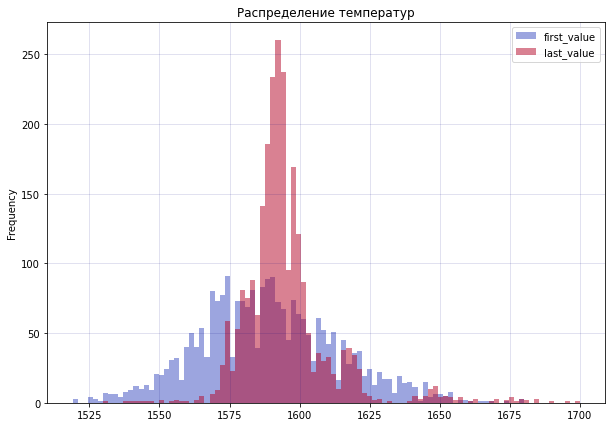

In [42]:
query = '''
WITH
temp_counts AS 
    (SELECT DISTINCT key,
            FIRST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime"),
            LAST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime" ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING),
            COUNT("Temperature") OVER (PARTITION BY key)
    FROM steel.data_temp)
SELECT *
FROM temp_counts
WHERE count > 1
  AND first_value > 1500
ORDER BY key;
'''
pd.read_sql_query(sql=query, con=engine)[['first_value', 'last_value']]\
                                          .plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                                                title='Распределение температур',
                                                xlabel='температура', ylabel='частота');

Разброс значений не такой большой. Начальная температура сплава колеблется больше, чем конечная - обычно она в пределах от 1550 до 1625. В последний замер температура чаще бывает от 1580 до 1600, меньше 1560 значений почти нет. Редко температуры превышают 1630.

Из этой таблицы для обучения возьмем только температуру первого и последнего замера. Количество замеров и отдельное время брать не будем, ведь они не влияют на температуру сплава.          
Составим запрос:

In [43]:
temp_query = '''
temp_fin AS 
    (SELECT DISTINCT key,
            FIRST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime") AS first_temp,
            LAST_VALUE("Temperature") OVER (PARTITION BY key ORDER BY "MesaureTime" ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
            AS last_temp,
            COUNT("Temperature") OVER (PARTITION BY key) AS measure_count
    FROM steel.data_temp)
'''
temp_filter = '''
      temp_fin.measure_count > 1
  AND temp_fin.first_temp > 1500
'''

query = '''
WITH '''+\
temp_query +\
'''
SELECT *
FROM temp_fin
WHERE''' +\
temp_filter +\
''';
'''
pd.read_sql_query(sql=query, con=engine)

,key,first_temp,last_temp,measure_count
0,1261,1573.0,1590.0,5
1,487,1619.0,1590.0,6
2,796,1679.0,1678.0,6
3,2197,1596.0,1606.0,3
4,2209,1576.0,1583.0,7
...,...,...,...,...
2466,1410,1604.0,1599.0,6
2467,1888,1627.0,1593.0,6
2468,1226,1608.0,1594.0,5
2469,242,1562.0,1578.0,4


### Предобработка

Для каждой таблицы в базе составлены запросы с фильтрами. Объединим таблицы, используя их:

In [44]:
merge_query = '''
WITH
''' +\
arcs_query + ',' +\
gas_query + ',' +\
bulk_query + ',' +\
wire_query + ',' +\
temp_query +\
'''
SELECT *
FROM temp_fin
JOIN arcs_fin
    ON temp_fin.key = arcs_fin.key
JOIN gas_fin
    ON temp_fin.key = gas_fin.key
JOIN bulk_fin
    ON temp_fin.key = bulk_fin.key
JOIN wire_fin
    ON temp_fin.key = wire_fin.key
WHERE
''' +\
temp_filter +\
'''
AND
''' +\
arcs_filter +\
''';
'''

data = pd.read_sql_query(sql=merge_query, con=engine)
data.head(3)

,key,first_temp,last_temp,measure_count,key,heat_count,total_heat_seconds,avg_active,avg_reactive,avg_ratio,...,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,key,Wire 1,Wire 2
0,1,1571.0,1613.0,5,1,5,1098.0,0.975629,0.636648,1.538898,...,43.0,NaN,NaN,NaN,206.0,150.0,154.0,1,60.059998,NaN
1,2,1581.0,1602.0,6,2,4,811.0,0.763150,0.499528,1.551834,...,73.0,NaN,NaN,NaN,206.0,149.0,154.0,2,96.052315,NaN
2,3,1596.0,1599.0,5,3,5,655.0,0.505176,0.319815,1.583120,...,34.0,NaN,NaN,NaN,205.0,152.0,153.0,3,91.160157,NaN


Получилась таблица из 25 столбцов. Уберем столбцы с ключом и `measure_count`, который использовали для фильтрации:

In [45]:
data = data.drop(['key', 'measure_count'], axis=1)
display(data.head(3))
data.info()

,first_temp,last_temp,heat_count,total_heat_seconds,avg_active,avg_reactive,avg_ratio,gas,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1571.0,1613.0,5,1098.0,0.975629,0.636648,1.538898,29.749986,NaN,NaN,43.0,NaN,NaN,NaN,206.0,150.0,154.0,60.059998,NaN
1,1581.0,1602.0,4,811.0,0.763150,0.499528,1.551834,12.555561,NaN,NaN,73.0,NaN,NaN,NaN,206.0,149.0,154.0,96.052315,NaN
2,1596.0,1599.0,5,655.0,0.505176,0.319815,1.583120,28.554793,NaN,NaN,34.0,NaN,NaN,NaN,205.0,152.0,153.0,91.160157,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2111 non-null   float64
 1   last_temp           2111 non-null   float64
 2   heat_count          2111 non-null   int64  
 3   total_heat_seconds  2111 non-null   float64
 4   avg_active          2111 non-null   float64
 5   avg_reactive        2111 non-null   float64
 6   avg_ratio           2111 non-null   float64
 7   gas                 2111 non-null   float64
 8   Bulk 1              168 non-null    float64
 9   Bulk 3              860 non-null    float64
 10  Bulk 4              746 non-null    float64
 11  Bulk 6              381 non-null    float64
 12  Bulk 10             129 non-null    float64
 13  Bulk 11             111 non-null    float64
 14  Bulk 12             1627 non-null   float64
 15  Bulk 14             1868 non-null   float64
 16  Bulk 1

Теперь в данных 19 признаков: начальная и последняя температура, количество нагреваний, общее время нагрева, средняя активная и реактивная мощность, соотношение мощностей, количество газа и количество разных сыпучих и проволочных материалов.

После объединения остались только данные о 2098 партях, в которых были два замера температуры и не было выбросов в остальных значениях. Пропуски есть только в количестве материалов. Заполним их:

In [46]:
data = data.fillna(0)
data.info()
print('Дубликаты :', data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   first_temp          2111 non-null   float64
 1   last_temp           2111 non-null   float64
 2   heat_count          2111 non-null   int64  
 3   total_heat_seconds  2111 non-null   float64
 4   avg_active          2111 non-null   float64
 5   avg_reactive        2111 non-null   float64
 6   avg_ratio           2111 non-null   float64
 7   gas                 2111 non-null   float64
 8   Bulk 1              2111 non-null   float64
 9   Bulk 3              2111 non-null   float64
 10  Bulk 4              2111 non-null   float64
 11  Bulk 6              2111 non-null   float64
 12  Bulk 10             2111 non-null   float64
 13  Bulk 11             2111 non-null   float64
 14  Bulk 12             2111 non-null   float64
 15  Bulk 14             2111 non-null   float64
 16  Bulk 1

Посмотрим, как распределены значения признаков:

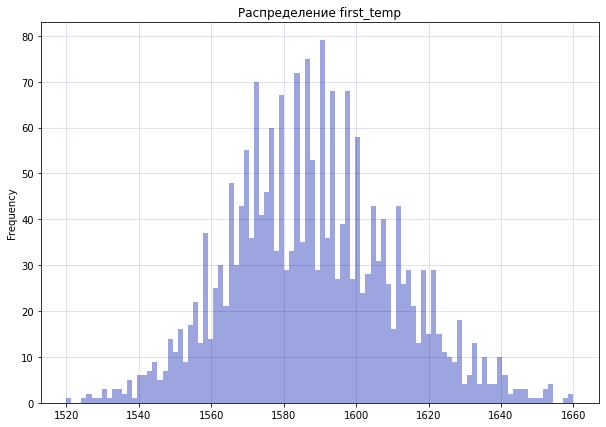

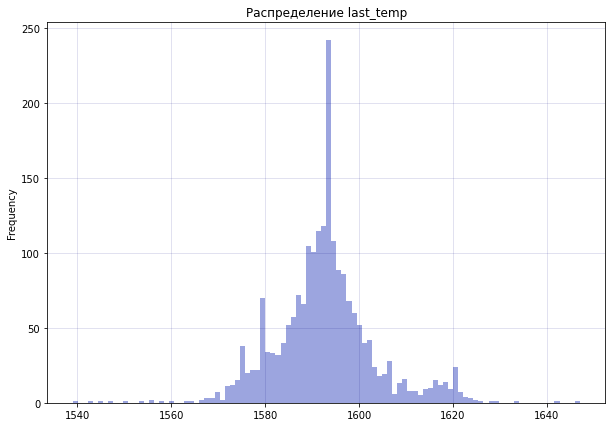

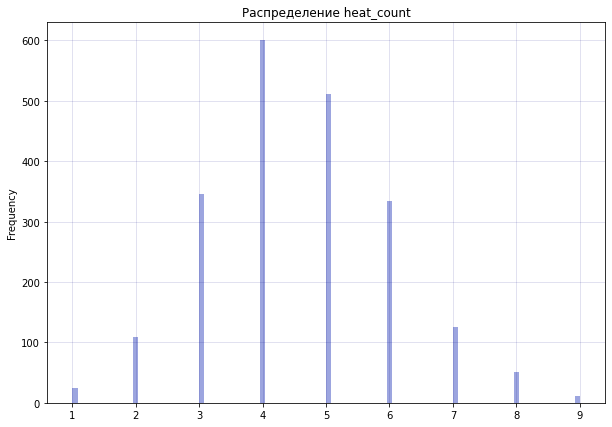

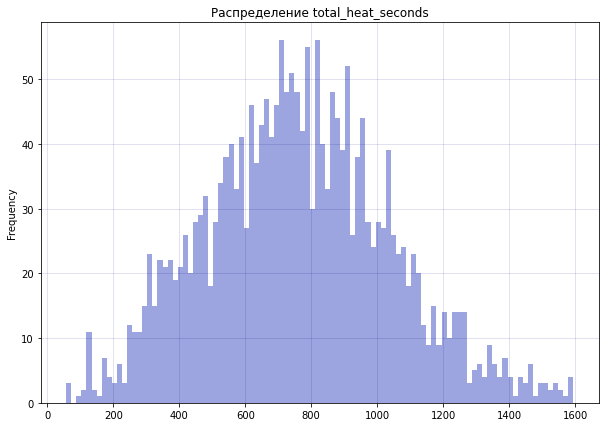

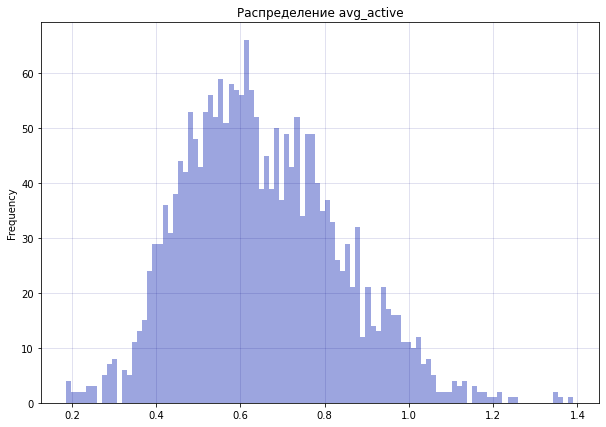

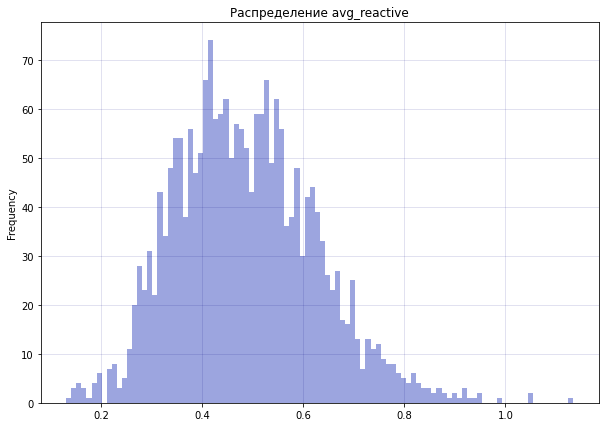

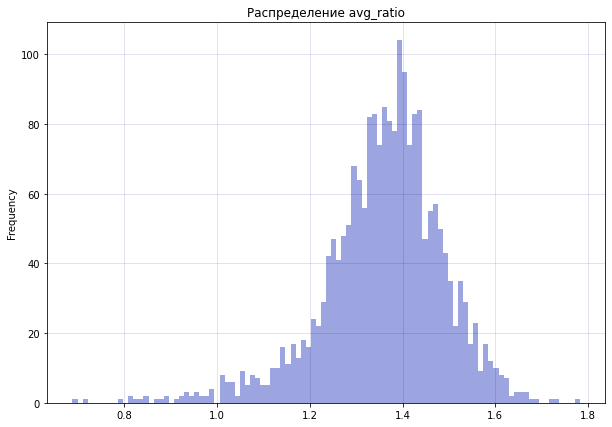

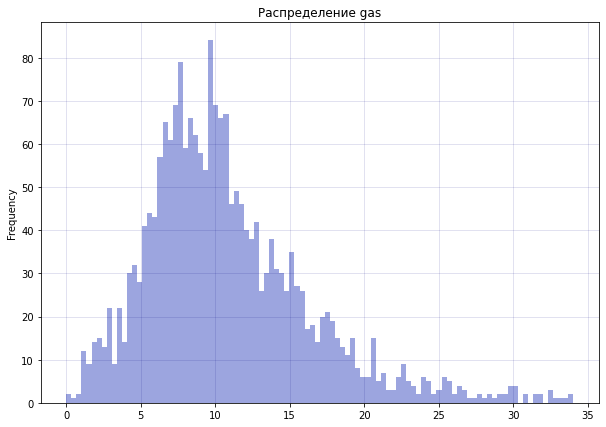

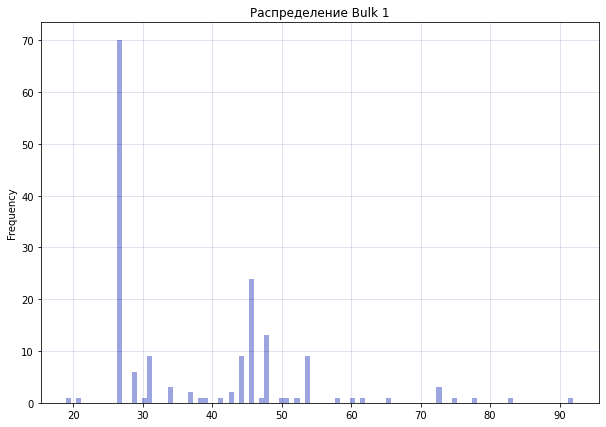

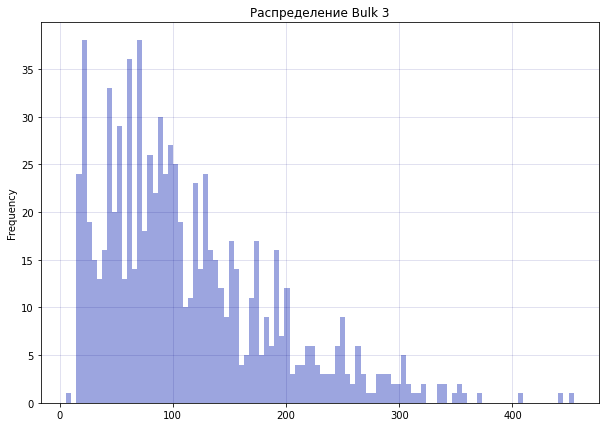

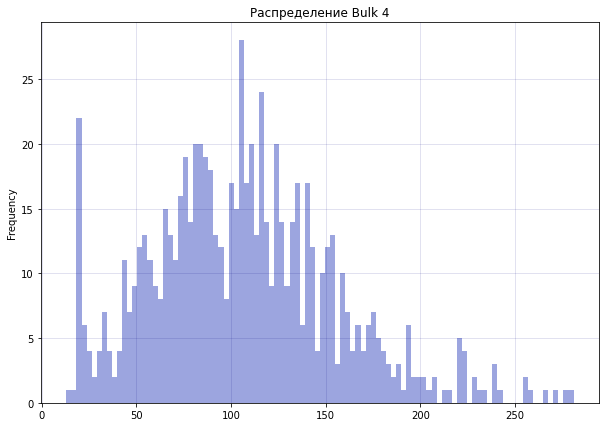

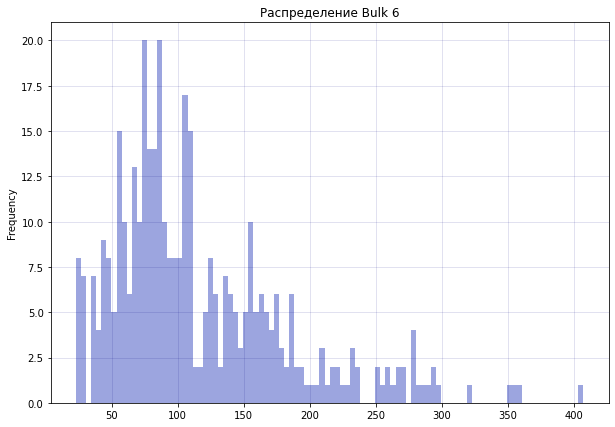

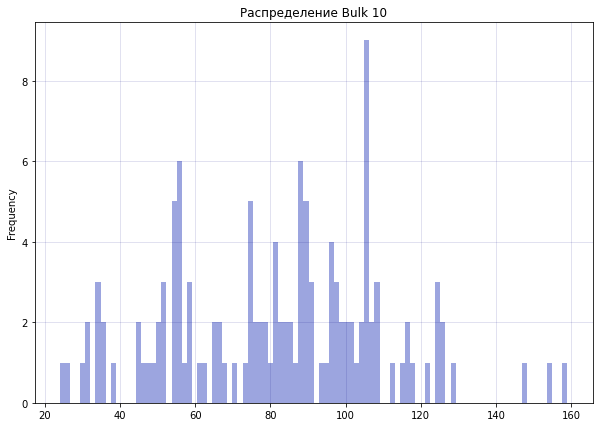

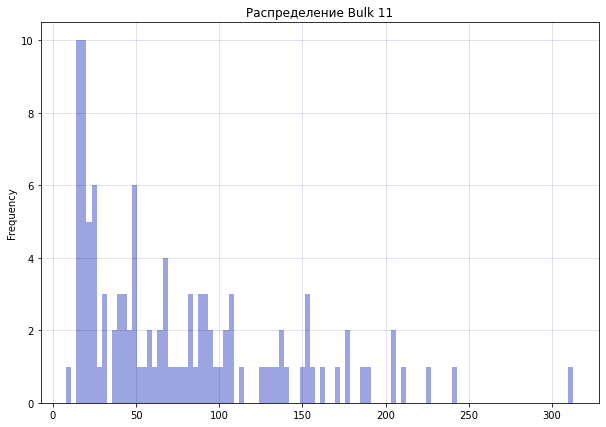

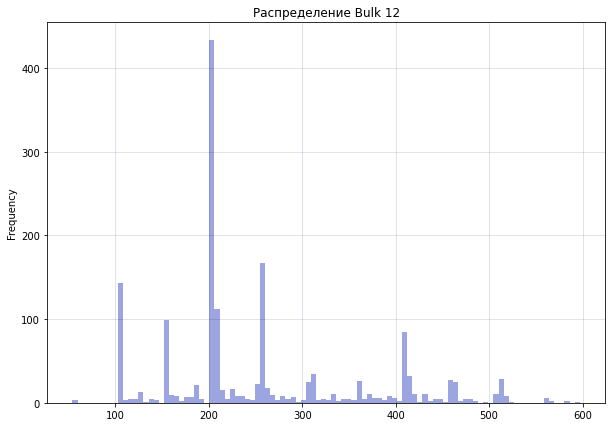

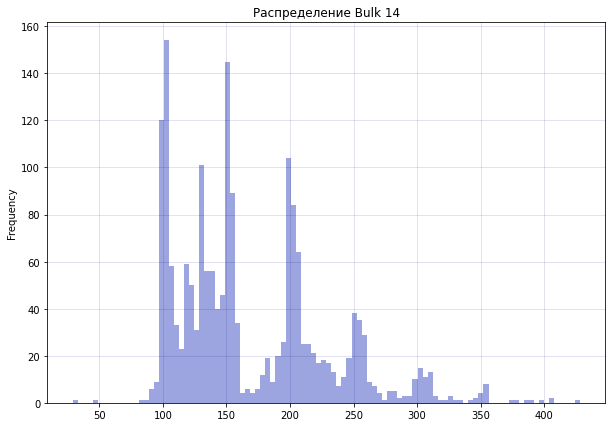

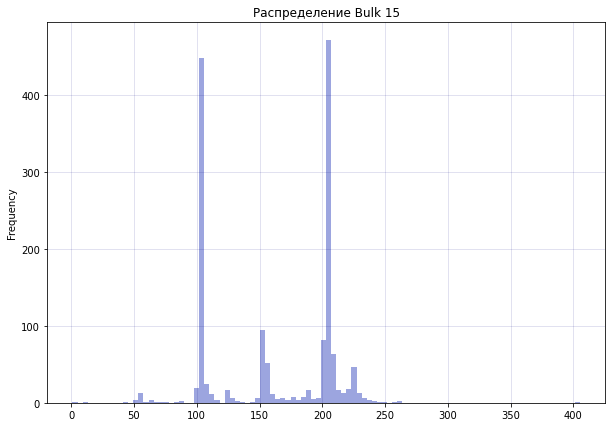

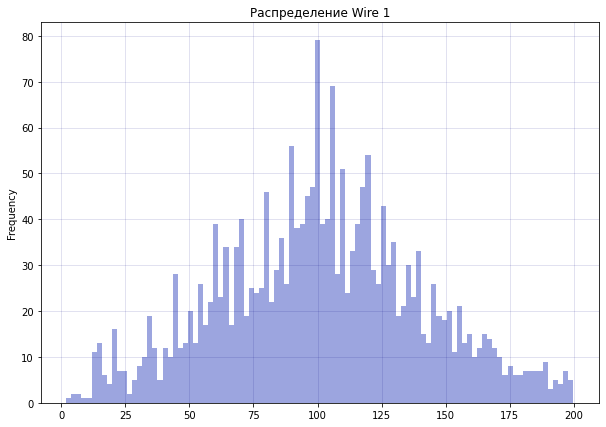

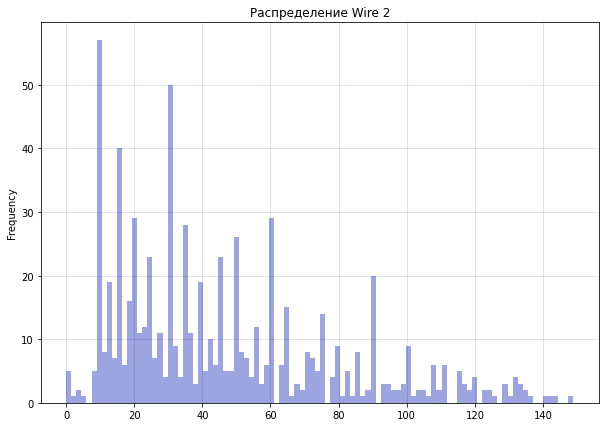

In [47]:
for n in data.columns:
    data[data[n] > 0][n].plot(kind='hist', bins=100, alpha=0.5, cmap=CMAP,
                title='Распределение ' + n,
                xlabel='значения', ylabel='частота')
    plt.show()

Распределение первых 9 признаков не изменилось.        
В материалах большинство значений было заполнено нулями - на графиках показаны остальные значения.
Материалы добавляют по-разному - некоторые добавляют только в определенном количестве, почти не меняя его от партии к партии, другие добавляют в разных количествах.

Посмотрим, какая зависимость есть у признаков с последней температурой:

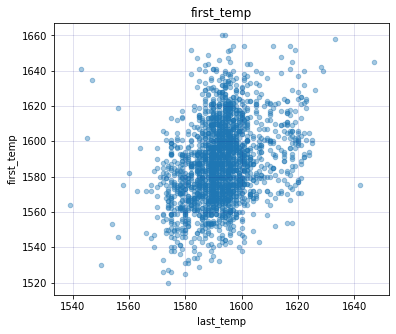

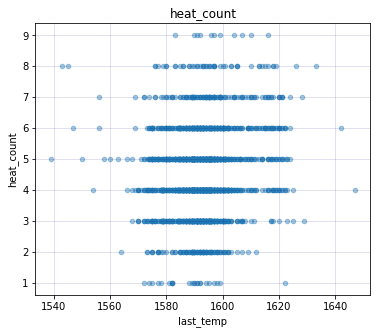

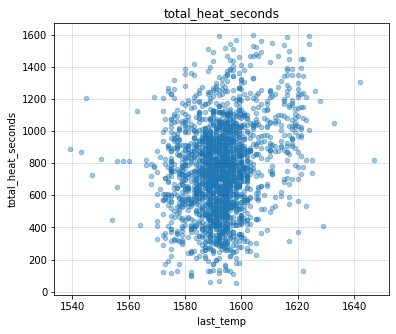

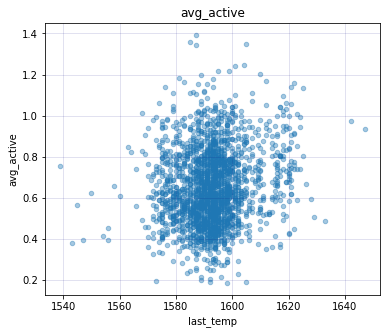

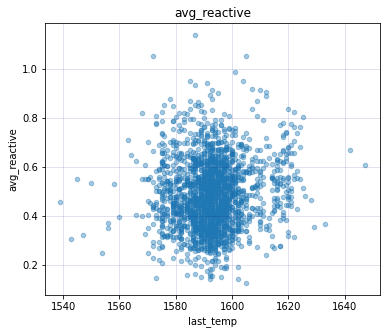

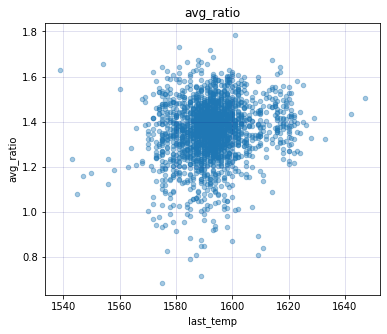

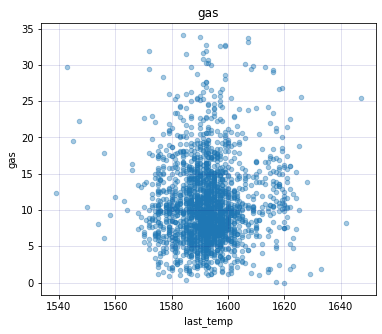

In [48]:
cols = ['first_temp', 'heat_count', 'total_heat_seconds',
        'avg_active', 'avg_reactive', 'avg_ratio', 'gas']
for n in cols:
    data[[n, 'last_temp']].plot(kind='scatter', x=1, y=0, alpha=0.4,
                                title='' + n,
                                ylabel=n, xlabel='last_temp', figsize=(6, 5))
    plt.show()

На графиках не видно зависимостей - в основном все значения находятся в середине графика и плавно расходятся из центра. `first_temp` - единственный столбец с которым у `last_temp` здесь видна слабая зависимость. Значения первой температуры растут, и вместе с ними растет финальная температура, но делают они это в широком диапазоне.

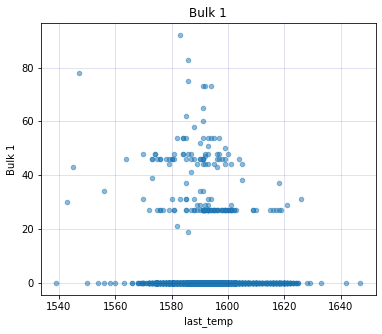

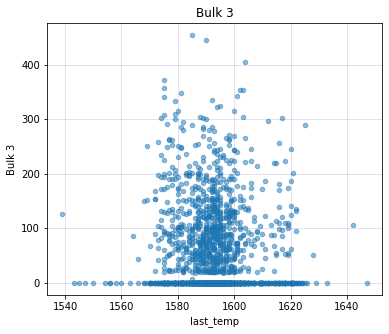

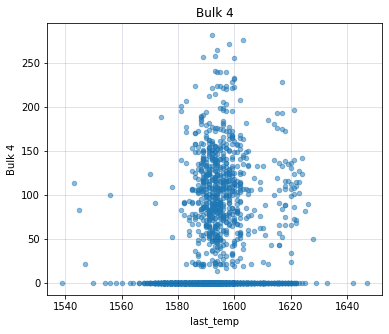

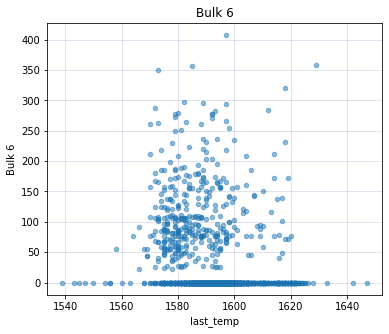

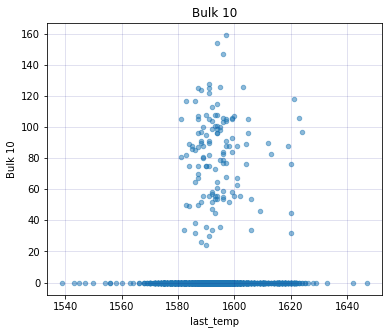

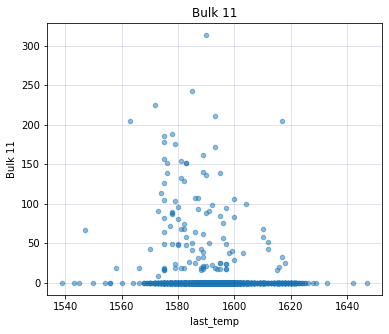

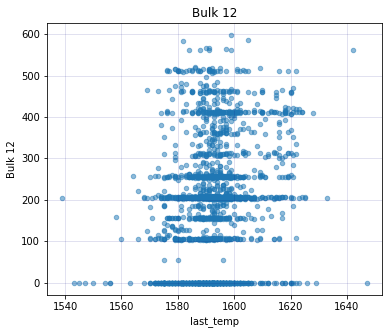

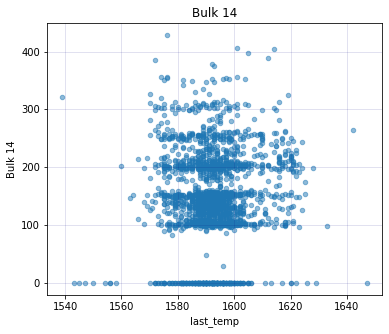

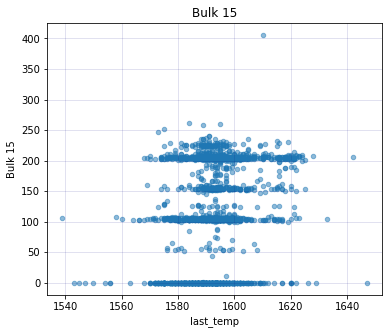

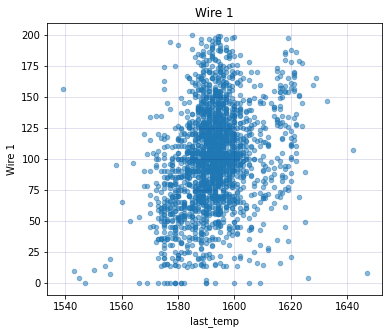

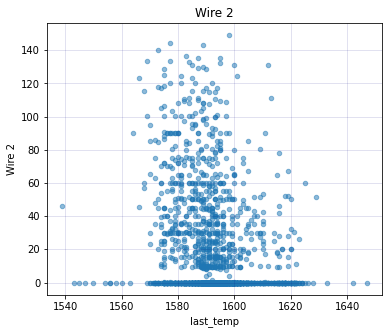

In [49]:
mats = ['Bulk 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 10', 'Bulk 11',
        'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2']
for n in mats:
    data[[n, 'last_temp']].plot(kind='scatter', x=1, y=0, alpha=0.5,
                                title='' + n,
                                ylabel=n, xlabel='last_temp', figsize=(6, 5))
    plt.show()

С количеством материалов также не видно прямых зависимостей.

Поосмотрим на корреляцию:

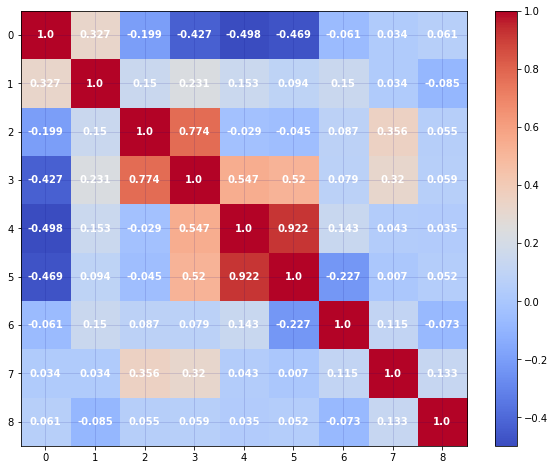

In [50]:
def plot_corr(data, title, xlabel, ylabel, colorbar):
    fig, (ax) = plt.subplots(ncols=1, figsize=(10, 8))
    cbmap = ax.imshow(data, interpolation=None, aspect='auto', cmap=CMAP);
    cb = plt.colorbar(cbmap, ax=ax)
    cb.set_label(colorbar)
    
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            text = ax.text(i, j, data.iloc[j, i],
                           ha="center", va="center",
                           color="w", fontweight='demi')
    
    ax.set_yticks(np.arange(data.shape[0]), labels=data.index)
    ax.set_xticks(np.arange(data.shape[1]), labels=data.columns)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")
    ax.set_title(title)
    ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
    ax.grid(False)
    plt.show()
    
plot_corr(data.iloc[:, :9].corr().round(3).T, 'Корреляция признаков', '', '', '')

Действительно, с финальной темературой нет сильной корреляции ни у одного признака, есть только небольшая с начальной температурой.    
У начальной температуры есть обратная корреляция с несколькими признаками - если она высокая, то время нагрева и мощность обычно требуются меньше. Сильно связаны реактивная и активная мощность, также корреляция есть у количества нагревов и времени.

## Обучение моделей

Для решения задачи обучим несколько классов моделей - линейную регрессию, случайный лес, градиентный бустинг и нейронные сети. Качество моделей будем оценивать метрикой MАЕ - она покажет, насколько предсказания отличаются от реальных значений. Дополнительно рассмотрим метрику R²: чем ближе она будет к единице, тем лучше модель научилась находить закономерности в данных.

### Подготовка выборок

Перед обучением поделим данные на тренировочную и тестовую выборки:

In [51]:
features = data.drop(['last_temp'], axis=1)
target = data['last_temp']

X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

In [52]:
print('Размер тренировочной выборки:', X_train.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер тренировочной выборки: (1583, 18)
Размер тестовой выборки: (528, 18)


Признаки в данных сильно отличаются по значениям. Чтобы использовать некоторые типы моделей данные нужно будет масштабировать.   
Данные для тестирования можно масштабировать сейчас, но при подборе гиперпараметров признаки можно преобразовывать только внутри кросс-валидации.

In [53]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:1]

array([[ 0.47597042,  1.6806806 ,  1.17293711, -0.25477617, -0.35162331,
         0.18001423,  0.8514406 ,  4.06584372, -0.63048676, -0.61652268,
         1.94399675, -0.25122736, -0.18328755,  0.08759748,  1.31858237,
        -0.13255406, -0.77453422,  0.1389068 ]])

Напишем функцию для поиска оптимальных гиперпараметров: на вход она будет принимает модель, сетку параметров и обучающую выборку; возвращать будет все результаты подбора.

In [54]:
def pipe_validate(model, param_grid, X_train, y_train):
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scoring = {'mae': 'neg_mean_absolute_error',
               'r2':'r2'}
    pipe = make_pipeline(StandardScaler(), model)
    search = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid,
                                scoring=scoring, refit='mae', verbose=1, cv=kf,
                                random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    print('лучшие параметры:', search.best_params_)
    print('МАЕ:', search.best_score_*-1)
    print('R²:', search.cv_results_['mean_test_r2'][search.best_index_])
    return search

Также напишем функцию для оценки качества модели: она покажет МАЕ и R² модели и график сравнения предсказаний и ответов:

In [55]:
def show_stats(y_test, preds):
    print('MAE:', mean_absolute_error(y_test, preds))
    print('R²:', r2_score(y_test, preds))
    print('среднее модели:', preds.mean())
    print('среднее ответов:', y_test.mean())
    
    plt.scatter(x=y_test, y=preds, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', alpha=0.4)
    plt.title('Предсказания модели')
    plt.xlabel('ответы'), plt.ylabel('предсказания')
    plt.legend(['предсказания модели', 'идеальные предсказания'], loc='upper right')
    plt.show()

Создадим список, в который будут занесены результаты обучения моделей:

In [56]:
stat_table = []

### Константная модель

Чтобы понять, обучается модель или нет, можно сравнить ее результаты с результатами константной модели. Возьмем модель, всегда предсказывающую среднее обучающей выборки:

MAE: 7.5182335037041295
R²: -0.0008934194041569921
среднее модели: 1592.6045483259634
среднее ответов: 1592.9204545454545


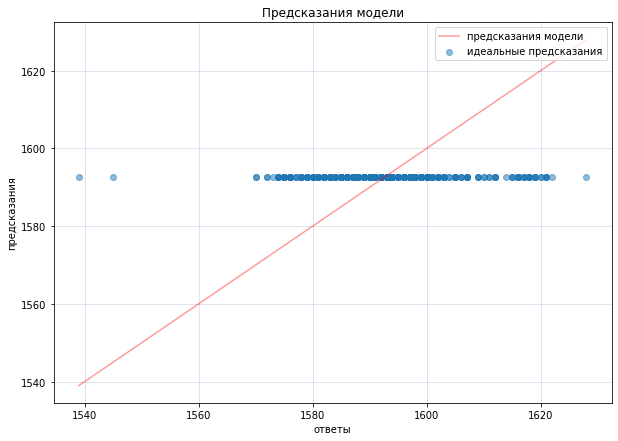

In [57]:
dumm = DummyRegressor(strategy="mean")
dumm.fit(X_train_scaled, y_train)
preds = dumm.predict(X_test_scaled)
show_stats(y_test, preds)

R² модели ожидаемо равно нулю: модель даже не пыталась искать зависимости в признаках. МАЕ равна 7.52 - ошибка обучаемых моделей точно должна быть меньше.    
Занесем метрики в таблицу:

In [58]:
stat_table.append(['Constant (mean)', mean_absolute_error(y_test, preds), 0])

### Ridge Regression

Первой обученной моделью будет гребневая регрессия. Подберем для нее регуляризацию `alpha`:

In [59]:
%%time
model = Ridge()

ridge_param = {'ridge__alpha': np.linspace(0.01, 100, num=50)}

ridge_pipe = pipe_validate(model, ridge_param, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
лучшие параметры: {'ridge__alpha': 63.26897959183673}
МАЕ: 5.968445577708933
R²: 0.43311437941265063
CPU times: user 2.12 s, sys: 1.62 s, total: 3.75 s
Wall time: 3.68 s


МАЕ лучшей модели равна 5.97 - меньше, чем у константной модели. R² гораздо лучше, чем ноль, но хорошей модель можно назвать только если коэффициент больше 0.7.     
Внесем результаты кросс-валидации в таблицу:

In [60]:
stat_table.append(['Ridge', ridge_pipe.cv_results_['mean_test_mae'][ridge_pipe.best_index_]*-1,\
                            ridge_pipe.cv_results_['mean_test_r2'][ridge_pipe.best_index_]])

### RandomForest

Следующая модель - случайный лес.

In [61]:
%%time
model = RandomForestRegressor(random_state=RANDOM_STATE)

forest_param = {'randomforestregressor__n_estimators':range(3, 66),
                'randomforestregressor__max_depth': range(2, 12),
                'randomforestregressor__min_samples_split': range(2, 6)}

forest_pipe = pipe_validate(model, forest_param, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
лучшие параметры: {'randomforestregressor__n_estimators': 53, 'randomforestregressor__min_samples_split': 3, 'randomforestregressor__max_depth': 7}
МАЕ: 6.096554522530259
R²: 0.3831249992166037
CPU times: user 5.18 s, sys: 2.18 ms, total: 5.19 s
Wall time: 5.19 s


Лучшая модель показывает МАЕ 6.09 и R² 0.38 - немного хуже, чем у Ridge.

In [62]:
stat_table.append(['RandomForest', forest_pipe.cv_results_['mean_test_mae'][forest_pipe.best_index_]*-1,\
                                   forest_pipe.cv_results_['mean_test_r2'][forest_pipe.best_index_]])

### XGBRegressor

Следующий тип модели - градиентный бустинг на деревьях.

In [63]:
%%time
model = xgb.XGBRegressor(random_state=RANDOM_STATE)

xgb_param = {'xgbregressor__n_estimators': range(1, 200, 10),
             'xgbregressor__learning_rate': [n/100 for n in range(1, 50)],
             'xgbregressor__max_depth': range(1, 10),
             'xgbregressor__reg_lambda':[n/100 for n in range(1, 10000, 100)]}

xgb_pipe = pipe_validate(model, xgb_param, X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
лучшие параметры: {'xgbregressor__reg_lambda': 98.01, 'xgbregressor__n_estimators': 91, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.19}
МАЕ: 6.030087817415101
R²: 0.38340108863050576
CPU times: user 1min 59s, sys: 1.08 s, total: 2min
Wall time: 2min 1s


МАЕ 6 и R² 0.41 - результат близок к случайному лесу. Похоже, деревья не очень подходят для решения этой задачи: в данных только численные признаки, в половине которых много нулей.

In [64]:
stat_table.append(['XGBoost', xgb_pipe.cv_results_['mean_test_mae'][xgb_pipe.best_index_]*-1,\
                              xgb_pipe.cv_results_['mean_test_r2'][xgb_pipe.best_index_]])

### Нейронная сеть

Последний класс моделей - нейронная сеть. Построим сеть с одним скрытым слоем и батч-нормализацией и подберем гиперпараметры:

In [65]:
%%time
class Model_NN(nn.Module):
    def __init__(self, momentum, n_hidden_neurons_1):
        super(Model_NN, self).__init__()
        torch.manual_seed(RANDOM_STATE)

        self.fc1 = nn.Linear(18, n_hidden_neurons_1)
        self.a1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1, momentum=momentum)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.a1(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x    


mae_scorer = make_scorer(mean_absolute_error)

skorch_regressor = NeuralNetRegressor(module=Model_NN, 
                                      device='cpu',
                                      verbose=0,
                                      optimizer=torch.optim.Adam,
                                      criterion = nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=mae_scorer, lower_is_better=True, name='MAE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='MAE', patience=10))])

params = {'neuralnetregressor__optimizer__lr': [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
          'neuralnetregressor__batch_size': [10, 20, 30, 40, 50],
          'neuralnetregressor__max_epochs': [50, 100, 250, 500],
          'neuralnetregressor__module__momentum': [n/10 for n in range(1, 10)],
          'neuralnetregressor__module__n_hidden_neurons_1': range(2, 17)
         }

skorch_pipe = pipe_validate(skorch_regressor, params, 
                            np.array(X_train, dtype=np.float32),
                            np.array(y_train, dtype=np.float32).reshape(-1,1))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
лучшие параметры: {'neuralnetregressor__optimizer__lr': 0.005, 'neuralnetregressor__module__n_hidden_neurons_1': 5, 'neuralnetregressor__module__momentum': 0.1, 'neuralnetregressor__max_epochs': 250, 'neuralnetregressor__batch_size': 20}
МАЕ: 5.964570204416911
R²: 0.426515116635421
CPU times: user 15min 44s, sys: 5.72 s, total: 15min 50s
Wall time: 15min 58s


Время обучения сети заметно больше, чем у других моделей, результат немного лучше, чем у Ridge. R² почти не изменился.

In [66]:
stat_table.append(['SkorchNN', skorch_pipe.cv_results_['mean_test_mae'][skorch_pipe.best_index_]*-1,\
                              skorch_pipe.cv_results_['mean_test_r2'][skorch_pipe.best_index_]])

## Тестирование модели

Рассмотрим таблицу с результатами обучения моделей:

In [66]:
pd.DataFrame(stat_table, columns=['model', 'MAE', 'R²']).style.background_gradient(cmap=CMAP, axis=0)

,model,MAE,R²
0,Constant (mean),7.518234,0.000000
1,Ridge,5.968446,0.433114
2,RandomForest,6.096555,0.383125
3,XGBoost,6.000025,0.414261
4,SkorchNN,5.955611,0.428220


Самый лучший результат показала нейронная сеть - у нее самая низкая ошибка и один из самых высоких R², хотя от других моделей он отличается всего на несколько сотых. В целом все модели показывают похожий (не очень высокий) уровень понимания зависимостей в данных.

Проверим лучшую модель на тестовых данных:

MAE: 6.025640083081795
R²: 0.36759076932595336
среднее модели: 1593.4454
среднее ответов: 1592.9204545454545


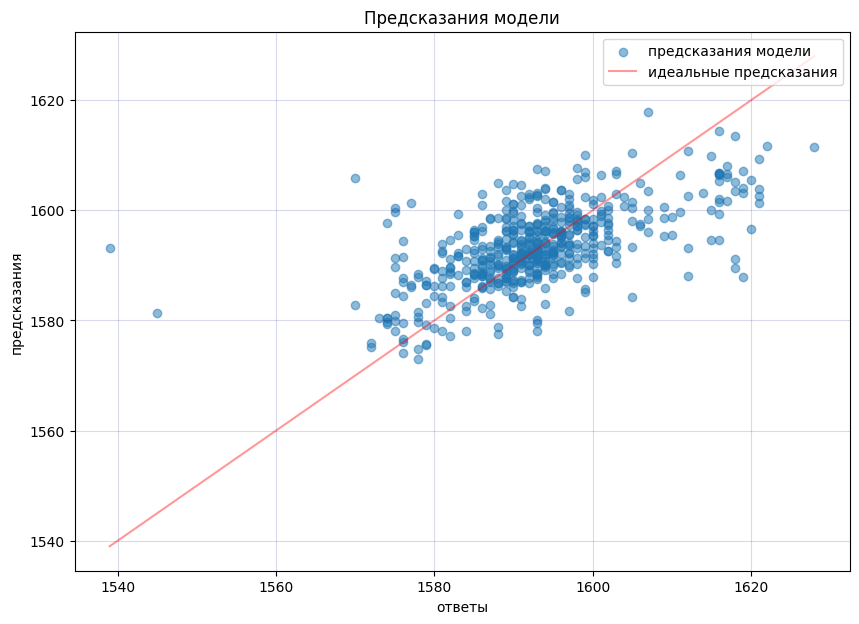

CPU times: total: 7.89 s
Wall time: 10.2 s


In [67]:
%%time
skorch_pipe.best_estimator_.fit(np.array(X_train_scaled, dtype=np.float32),
                                np.array(y_train, dtype=np.float32).reshape(-1,1))
preds = skorch_pipe.best_estimator_.predict(np.array(X_test_scaled, dtype=np.float32))
show_stats(y_test, preds)

Ошибка увеличилась на несколько сотых - МАЕ на тесте равна 6.02. Предсказания на графике выстроены по диагонали, есть отдельные далеко расположенные точки.

Для лучшей модели не доступна информация о важности признаков. Чтобы оценить их важность, придется воспользоваться техникой `permutation importance`: 
в ней значения каждого признака по отдельности перемешиваются, модель делает предсказания и сравниваются метрики до и после. Чем хуже метрика после перемешивания, тем сильнее модель зависела от этого признака.

In [68]:
%%time
importances = permutation_importance(skorch_pipe.best_estimator_,
                                     np.array(X_train_scaled, dtype=np.float32),
                                     np.array(y_train, dtype=np.float32).reshape(-1,1),
                                     n_repeats=30,
                                     random_state=0)

CPU times: total: 19.2 s
Wall time: 22.2 s


In [70]:
feature_importance = []
for i in importances.importances_mean.argsort()[::-1]:
    feature_importance.append([features.columns[i],
                               importances.importances_mean[i]])
pd.DataFrame(feature_importance).style.background_gradient(cmap=CMAP, axis=0)

,0,1
0,first_temp,0.683348
1,total_heat_seconds,0.219099
2,avg_active,0.206867
3,Bulk 6,0.068313
4,Wire 1,0.053536
5,heat_count,0.048874
6,avg_ratio,0.046892
7,Bulk 1,0.045178
8,Wire 2,0.044463
9,Bulk 3,0.040909


Модель показывает, что всего три признака сильно влияют на целевой: начальная температура, общее время нагрева и средняя активная мощость. Также как в анализе, самая сильная зависимость целевого признака была от начальной температуры. Выведем график еще раз:

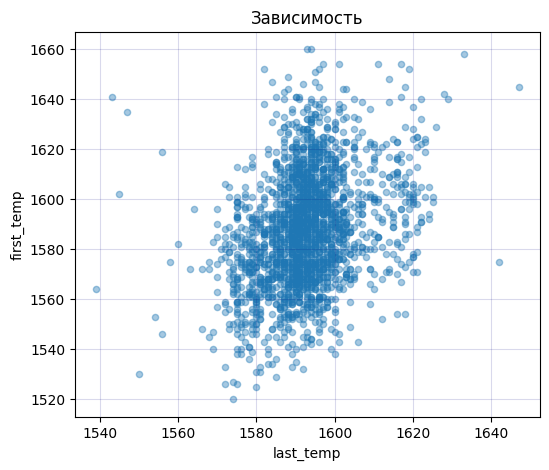

Корреляция: 0.3274582163026865


In [71]:
data[['first_temp', 'last_temp']].plot(kind='scatter', x=1, y=0, alpha=0.4,
                                title='Зависимость',
                                ylabel='first_temp', xlabel='last_temp', figsize=(6, 5))
plt.show()
print('Корреляция:', data[['first_temp', 'last_temp']].corr().iloc[0, 1])

## Вывод

Данные в базе расположены в нескольких таблицах. Кажая таблица была обработана отдельно: удалены аномалии, обработаны пропуски, выделены полезные признаки и сгенерированы новые. После обработки и объединения таблиц в данных стало 19 признаков: начальная и последняя температура, количество нагреваний, общее время нагрева, средняя активная и реактивная мощность, соотношение мощностей, количество газа и количество разных сыпучих и проволочных материалов. В обработанных данных были найдены следующие закономерности:
- если температура сплава в начале обработки высокая, то время нагрева и мощность обычно требуются меньше;
- начальная температура сплава колеблется больше, чем конечная - обычно она в пределах от 1550 до 1625. В последний замер температура чаще бывает от 1580 до 1600;
- часто активная мощность больше реактивной в 1.4 раза, их соотношение находится в пределах от 1.2 до 1.5;
- с увеличением количества нагревов растет количество используемого газа.

После анализа были подготовлены выборки для обучения моделей.    
Для сравнения первой моделью была константная, всегда предсказывающая среднее тренировочной выборки - качество обучаемых моделей должно быть выше ее.    
Для решения задачи были выбраны 4 модели: гребневая регрессия, случайный лес, градиентный бустинг и нейронная сеть. После подбора гиперпараметров все они показали ошибку МАЕ меньше, чем у константой модели. R² у всех был очень близко - в среднем 0.42. Это не очень высокий уровень понимания зависимостей в данных, но, как было видно в анализе, между признаками зависимостей особо не было.     
Лучший результат на обучении показала нейронная сеть - ее МАЕ равна 5.57. На тесте ошибка выросла и стала почти 6. В целом предсказания модели близки к ответам. На графике сравнения предсказаний и ответов точки выстроены полосой в направлении идеальных ответов, хотя есть отдельные далеко расположенные точки.       
Гребневая регрессия показала средний результат, а случайный лес и градиентный бустинг показали самые плохие результаты - деревья не очень подходят для решения этой задачи, ведь в данных только численные признаки, в половине которых много нулей.

Самыми важными признаками для лучшей модели стали начальная температура, общее время нагрева и средняя активная мощость. Больше всего на конечную температуру влияет начальная.

Для улучшения предсказаний можно добавить новых признаков - может, данные об объеме партии или даже составе сплава.     
Возможно, из признаков стоило удалить количество нагреваний в партии: оно растет вместе с общим временем нагрева, что логично, но при этом оно почти не связано с другими признаками.
Также не для каждой стадии обработки было указано время - нельзя было выстроить хронологию процессов и проанализировать изменение температуры во времени.

Саму модель можно улучшить, если еще поэксперементировать с архитектурой: количеством слоев и их типами.
